**Regdiffusion integrated into PySCENIC workflow**

author: Nicky-Jin

date: 2025-03-15


# In the beginning

Usually, I perform gene regulatory network (GRN) inference with **PySCENIC**, which provide a workflow including:

-   **GRN inference**

-   **Pruning:** Refines co-expression modules using cisTarget to retain genes with TF-binding motifs.

-   **Cell Scoring:** Quantifies TF activity in individual cells via AUCell

However, PySCENIC runs GRNBoost2 or GENIE3 first, which are computationally intensive, especially for large datasets. By contrast, **RegDiffusion** proposes a very fast way to build a **GRN**. I integrated RegDiffusion into the workflow of PySCENIC, and the results turned out to be satisfying.

# Preparations

In [13]:
import loompy as lp
import numpy as np
import scanpy as sc
import pandas as pd
import regdiffusion as rd
import anndata as ad
import csv
import matplotlib.pyplot as plt
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import adjustText
import matplotlib
import seaborn as sns

data_dir = "../origin_data/"
output_dir = "../output/"

Single-cell transcriptome data used here were from **GSE276682** (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE276682).

I used data of mice lungs from control group (n=3) and model group (n=3), which were administered with intraperitoneal injection of 30mg/ml lipopolysaccharide (LPS) in saline to induce acute lung injury.

I downloaded raw data in FASTQ, used cellranger to generate expression matrix, and preprocessed the data following the **Scanpy** tutorials.

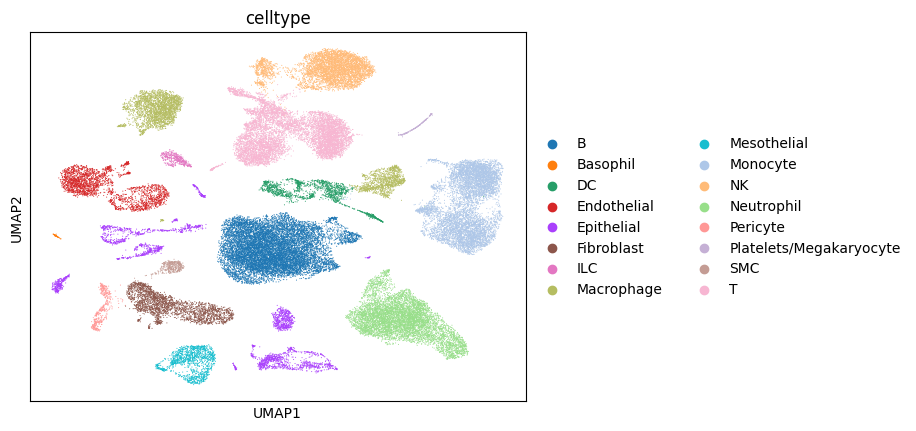

In [15]:
# Data have already been preprocessed
adata = sc.read(f"{output_dir}/samples_cluster_ann.h5ad")
sc.pl.umap(adata, color=["celltype"])

I used the auxilliary datasets recommended by PySCENIC pipeline, which includes:
* **The whole genome**: https://resources.aertslab.org/cistarget/databases/

* **Motif to TF annotations database**: https://resources.aertslab.org/cistarget/motif2tf/


For example, I downloaded the following files:

https://resources.aertslab.org/cistarget/databases/mus_musculus/mm10/refseq_r80/mc_v10_clust/gene_based/mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather

https://resources.aertslab.org/cistarget/databases/mus_musculus/mm10/refseq_r80/mc_v10_clust/gene_based/mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather

https://resources.aertslab.org/cistarget/motif2tf/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl

In [16]:
# Filter the gene not present in the cisTargetDB.

#!pip install pyarrow
cisdb = pd.read_feather(f'{data_dir}/mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather')
cis_genes = cisdb.columns.tolist()

genes = adata.var_names.tolist()

common_genes = list(set(genes) & set(cis_genes))
adata = adata[:, adata.var_names.isin(common_genes)].copy()

In [21]:
# Use counts matrix
adata.X = adata.layers["counts"].copy()
sc.pp.filter_genes(adata, min_cells=5)
print(np.max(adata.X))
print(adata.X.shape)

# Just log transform the data
sc.pp.log1p(adata)
print(type(adata.X))

# Get a numpy array
mat = adata.X.toarray()
print(type(mat))

6604.0
(55129, 3206)
<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.ndarray'>


In [ ]:
# Save the matrix
expr = pd.DataFrame(mat)
expr.index = adata.obs.index 
expr.columns = adata.var_names  

# Create a loom file for further use in PySCENIC
lp.create(
    filename=f'{output_dir}/mat_for_step1.loom',
    layers={"": expr.values.T},  
    row_attrs={"Gene": expr.columns.values.astype("str")},
    col_attrs={"CellID": expr.index.values.astype("str")}
)

# Regdiffusion

## GRN Inference

I use a NVIDIA RTX A2000 (6G), and it caused me less than 1 minute to build GRN on 55129 cells X 3206 genes.

In [20]:
rd_trainer = rd.RegDiffusionTrainer(mat)
rd_trainer.train()

Training loss: 0.200, Change on Adj: -0.000: 100%|██████████| 1000/1000 [00:51<00:00, 19.41it/s]


## GRN object

In [22]:
grn = rd_trainer.get_grn(adata.var_names)
grn

grn.to_hdf5(f'{output_dir}/grn_naive.hdf5')

# Prunning

## Data preparation

Need to transform my GRN into a long table, to make sure that it meet the input requirements of PySCENIC.

In [46]:
grn = rd.read_hdf5(f'{output_dir}grn_naive.hdf5')

data = pd.DataFrame(grn.adj_matrix)
data.index = [name.decode('utf-8') for name in grn.tf_names]
data.columns =  [name.decode('utf-8') for name in grn.gene_names]

long_df = data.stack().reset_index()
long_df.columns = ['TF', 'target', 'importance']

long_df = long_df[long_df['importance'] != 0]

long_df.to_csv(
    f"{output_dir}/grn_naive.tsv",
    sep="\t",
    index=False,
    quoting=csv.QUOTE_NONE,
    quotechar='',
    escapechar="\t"
)

In [47]:
long_df

/home/wanggang/miniconda3/envs/Regdiff-env/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


TF         target  importance
2         Xkr4          Sox17    0.336182
4         Xkr4          Sntg1    1.073242
5         Xkr4  2610203C22Rik    0.133545
6         Xkr4  1700034P13Rik    0.258301
7         Xkr4        Ppp1r42    0.476318
...        ...            ...         ...
10278430  Mid1          Vegfd    1.723633
10278431  Mid1          Gpm6b    1.765625
10278432  Mid1          Egfl6    0.624023
10278433  Mid1         Frmpd4    0.207031
10278434  Mid1        Arhgap6    1.208008

[6296845 rows x 3 columns]

## Run pyscenic ctx

I use conda environment *pyscenic-env*, created as follow:

```{linux}
conda create -y -n pyscenic-env python=3.10
conda activate pyscenic-env
pip install pyscenic==0.12.1
pip install numpy==1.23.5
pip install pandas==1.5.3
```

The following step cost 21 minutes.

In [26]:
## inputs
f_loom_grn=f"{output_dir}mat_for_step1.loom"
grn_output=f'{output_dir}grn_naive.tsv'

## outputs
f_loom_grn_aucell=f"{output_dir}mat_out.loom"
ctx_output=f'{output_dir}grn_reg.tsv'

## reference
f_motif_path=f'{data_dir}motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl'
f_db_500bp=f'{data_dir}mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'
f_db_10kb=f'{data_dir}mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'

!conda run -n pyscenic-env pyscenic ctx \
    {grn_output} \
    {f_db_500bp} {f_db_10kb} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_grn} \
    --output {ctx_output} \
    --num_workers 10


2025-03-15 14:31:11,594 - pyscenic.cli.pyscenic - INFO - Creating modules.

2025-03-15 14:31:13,429 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-03-15 14:31:18,974 - pyscenic.utils - INFO - Calculating Pearson correlations.

2025-03-15 14:31:19,761 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2025-03-15 14:32:07,335 - pyscenic.utils - INFO - Creating modules.

2025-03-15 14:32:30,114 - pyscenic.cli.pyscenic - I

# Cell Scoring

Quantifies regulon activity in individual cells via AUCell.
The following step cost me 1.5 minutes.

In [30]:
!conda run -n pyscenic-env pyscenic aucell {f_loom_grn} \
    {ctx_output} \
    --output {f_loom_grn_aucell} \
    --num_workers 10

Create regulons from a dataframe of enriched features.
Additional columns saved: []


2025-03-15 14:55:52,580 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-03-15 14:55:54,771 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.

2025-03-15 14:55:55,159 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2025-03-15 14:56:15,702 - pyscenic.cli.pyscenic - INFO - Writing results to file.
/home/wanggang/miniconda3/envs/pyscenic-env/lib/python3.10/site-packages/pyscenic/cli/utils.py:347: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, threshold in auc_thresholds.iteritems()



# Downstream Analysis

## Extract the AUCell scoring matrix

In [33]:
lf = lp.connect(f_loom_grn_aucell, mode="r+", validate=False)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()
auc_mtx.to_csv(f"{output_dir}/grn_ras.csv")

ad_auc_mtx = ad.AnnData(auc_mtx)
ad_auc_mtx.write(f"{output_dir}/grn_ras.h5ad")

## Integrate matrix
Load the AUCell scoring matrix into our `scanpy.Anndata`

In [6]:
adata = sc.read(f"{output_dir}/samples_cluster_ann.h5ad")
ad_auc_mtx = sc.read(f"{output_dir}/grn_ras.h5ad")
adata.obsm["X_aucell"] = ad_auc_mtx.X

## Cell type specific regulons

### Regulon specificity score

In [9]:
auc_mtx = pd.read_csv(f"{output_dir}/grn_ras.csv", index_col = 0)
rss = regulon_specificity_scores(auc_mtx, adata.obs.celltype) 
# Meet a bug in the function a cause de version of numpy. Change `np.float` in rss.py to `float`, and restart Kernel.
rss

Atf3(+)   Atf5(+)  Bcl11a(+)  Bcl11b(+)  Bcl6b(+)  Cebpd(+)   Crem(+)   Ebf1(+)   Ebf2(+)   Egr1(+)  ...   Tcf4(+)   Tcf7(+)  Tcf7l1(+)  Tcf7l2(+)  Tead1(+)  Tead4(+)   Thrb(+)  Trp63(+)  \
B                        0.262717  0.173119   0.600427   0.341219  0.296538  0.254898  0.472757  0.622744  0.201180  0.293659  ...  0.466845  0.361901   0.285199   0.279282  0.237318  0.197260  0.321345  0.295323   
Macrophage               0.298732  0.167654   0.179970   0.183755  0.208856  0.262456  0.192834  0.200338  0.210096  0.292953  ...  0.269520  0.199016   0.240419   0.329231  0.239790  0.181458  0.247154  0.224610   
Neutrophil               0.258015  0.168884   0.197074   0.216305  0.213269  0.263156  0.208120  0.187254  0.174142  0.274485  ...  0.181952  0.196946   0.228306   0.326656  0.236489  0.173230  0.233235  0.235438   
Monocyte                 0.291496  0.168756   0.247719   0.227491  0.232079  0.282139  0.228278  0.222893  0.266220  0.291860  ...  0.243255  0.223621   0.253694   0.388348  0.224135  0.190674  0.245435  0.217317   
NK                       0.200713  0.168898   0.239871   0.323437  0.225105  0.199838  0.326240  0.236846  0.174346  0.216071  ...  0.213227  0.307914   0.229165   0.223437  0.185841  0.179699  0.244054  0.209474   
T                        0.227317  0.170814   0.305564   0.513629  0.309422  0.224322  0.395978  0.295471  0.184096  0.247229  ...  0.223634  0.515733   0.263248   0.243447  0.215807  0.200817  0.299483  0.278819   
Mesothelial              0.236769  0.247809   0.172770   0.167765  0.173748  0.234632  0.170473  0.171580  0.282415  0.239248  ...  0.189342  0.171343   0.254410   0.192288  0.281632  0.177531  0.227795  0.210241   
Pericyte                 0.186857  0.227022   0.169401   0.170043  0.181470  0.196261  0.169693  0.175548  0.202689  0.195735  ...  0.193870  0.170805   0.205721   0.177325  0.207001  0.182000  0.198532  0.185650   
Endothelial              0.199636  0.169383   0.190527   0.177310  0.485659  0.218496  0.185818  0.192006  0.208317  0.229278  ...  0.292393  0.194703   0.241207   0.209012  0.242383  0.691200  0.240030  0.213166   
DC                       0.225334  0.168053   0.207460   0.188480  0.200146  0.214592  0.203466  0.204449  0.179645  0.212761  ...  0.226840  0.193978   0.203227   0.218833  0.194012  0.171315  0.204366  0.191504   
Epithelial               0.310945  0.170481   0.200002   0.183757  0.217855  0.286185  0.185109  0.186544  0.193954  0.280063  ...  0.200590  0.190639   0.313894   0.224763  0.344046  0.229757  0.332837  0.442866   
Fibroblast               0.298958  0.667952   0.175464   0.168382  0.198296  0.364977  0.174556  0.190531  0.525312  0.294940  ...  0.230923  0.177914   0.335861   0.212451  0.350350  0.178894  0.252502  0.204509   
Platelets/Megakaryocyte  0.169765  0.168196   0.170275   0.170223  0.173911  0.170068  0.170295  0.168525  0.171151  0.174464  ...  0.175365  0.171053   0.174878   0.172065  0.170082  0.173724  0.175615  0.175113   
SMC                      0.195224  0.219936   0.168868   0.169030  0.172576  0.213692  0.169920  0.170603  0.214318  0.196091  ...  0.181514  0.171886   0.205125   0.177592  0.212104  0.174800  0.196920  0.181248   
ILC                      0.183565  0.167745   0.177343   0.187902  0.176930  0.180852  0.185909  0.175596  0.169558  0.180879  ...  0.178943  0.185445   0.181995   0.179110  0.185638  0.174938  0.187739  0.177366   
Basophil                 0.172336  0.167847   0.169002   0.170010  0.169290  0.172158  0.169922  0.168796  0.171976  0.170929  ...  0.169424  0.169445   0.170309   0.171219  0.170379  0.171295  0.170844  0.170110   

                           Wt1(+)   Zeb1(+)  
B                        0.267328  0.394475  
Macrophage               0.235803  0.194857  
Neutrophil               0.237611  0.203085  
Monocyte                 0.238069  0.226920  
NK                       0.230828  0.292324  
T                        0.247114  0.461820  
Mesothelial              0.3383

In [19]:
range(1,len(cats)+1)

range(1, 17)

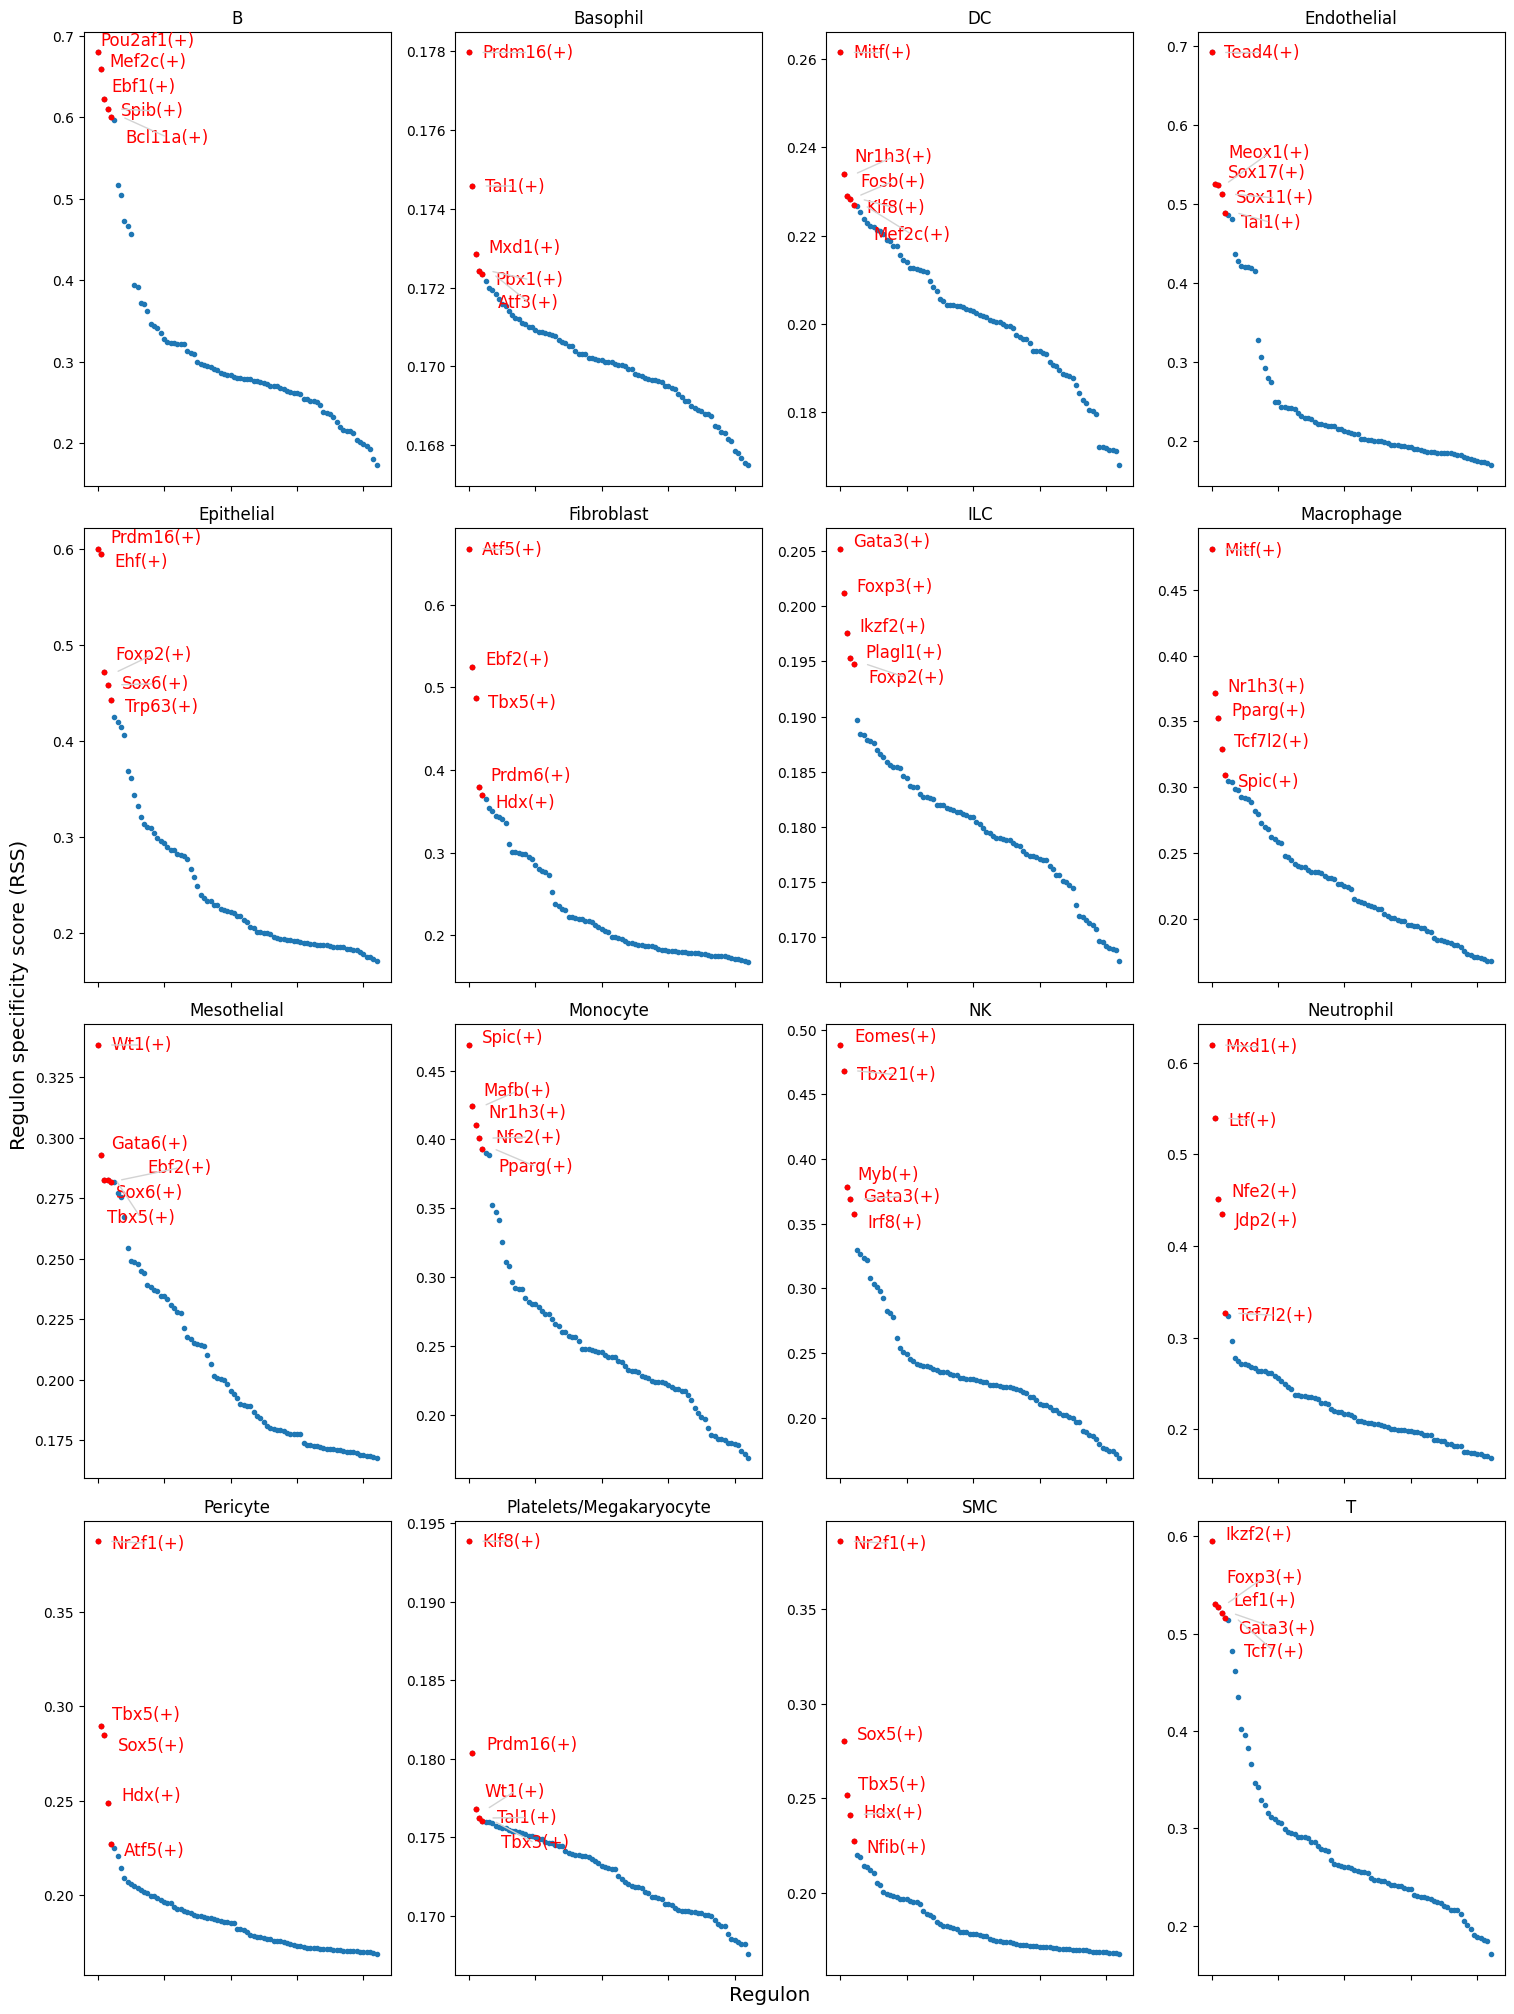

In [22]:
cats = sorted(list(set(adata.obs['celltype'])))

fig = plt.figure(figsize=(15, 20))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss.T[c]
    ax = fig.add_subplot(4,4,num)
    plot_rss(rss, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjustText.adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001)
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
#plt.savefig("cellType-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

Top 5 regulons from each cell type.

In [33]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

### Z-score

Calculate a Z-score for each regulon.

In [23]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)

### Heatmap

In [29]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=matplotlib.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [27]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict(zip( cats, colors ))
colormap = [colorsd[x] for x in adata.obs['celltype']]

/home/wanggang/miniconda3/envs/Regdiff-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wanggang/miniconda3/envs/Regdiff-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, -70.20555555555582, '')

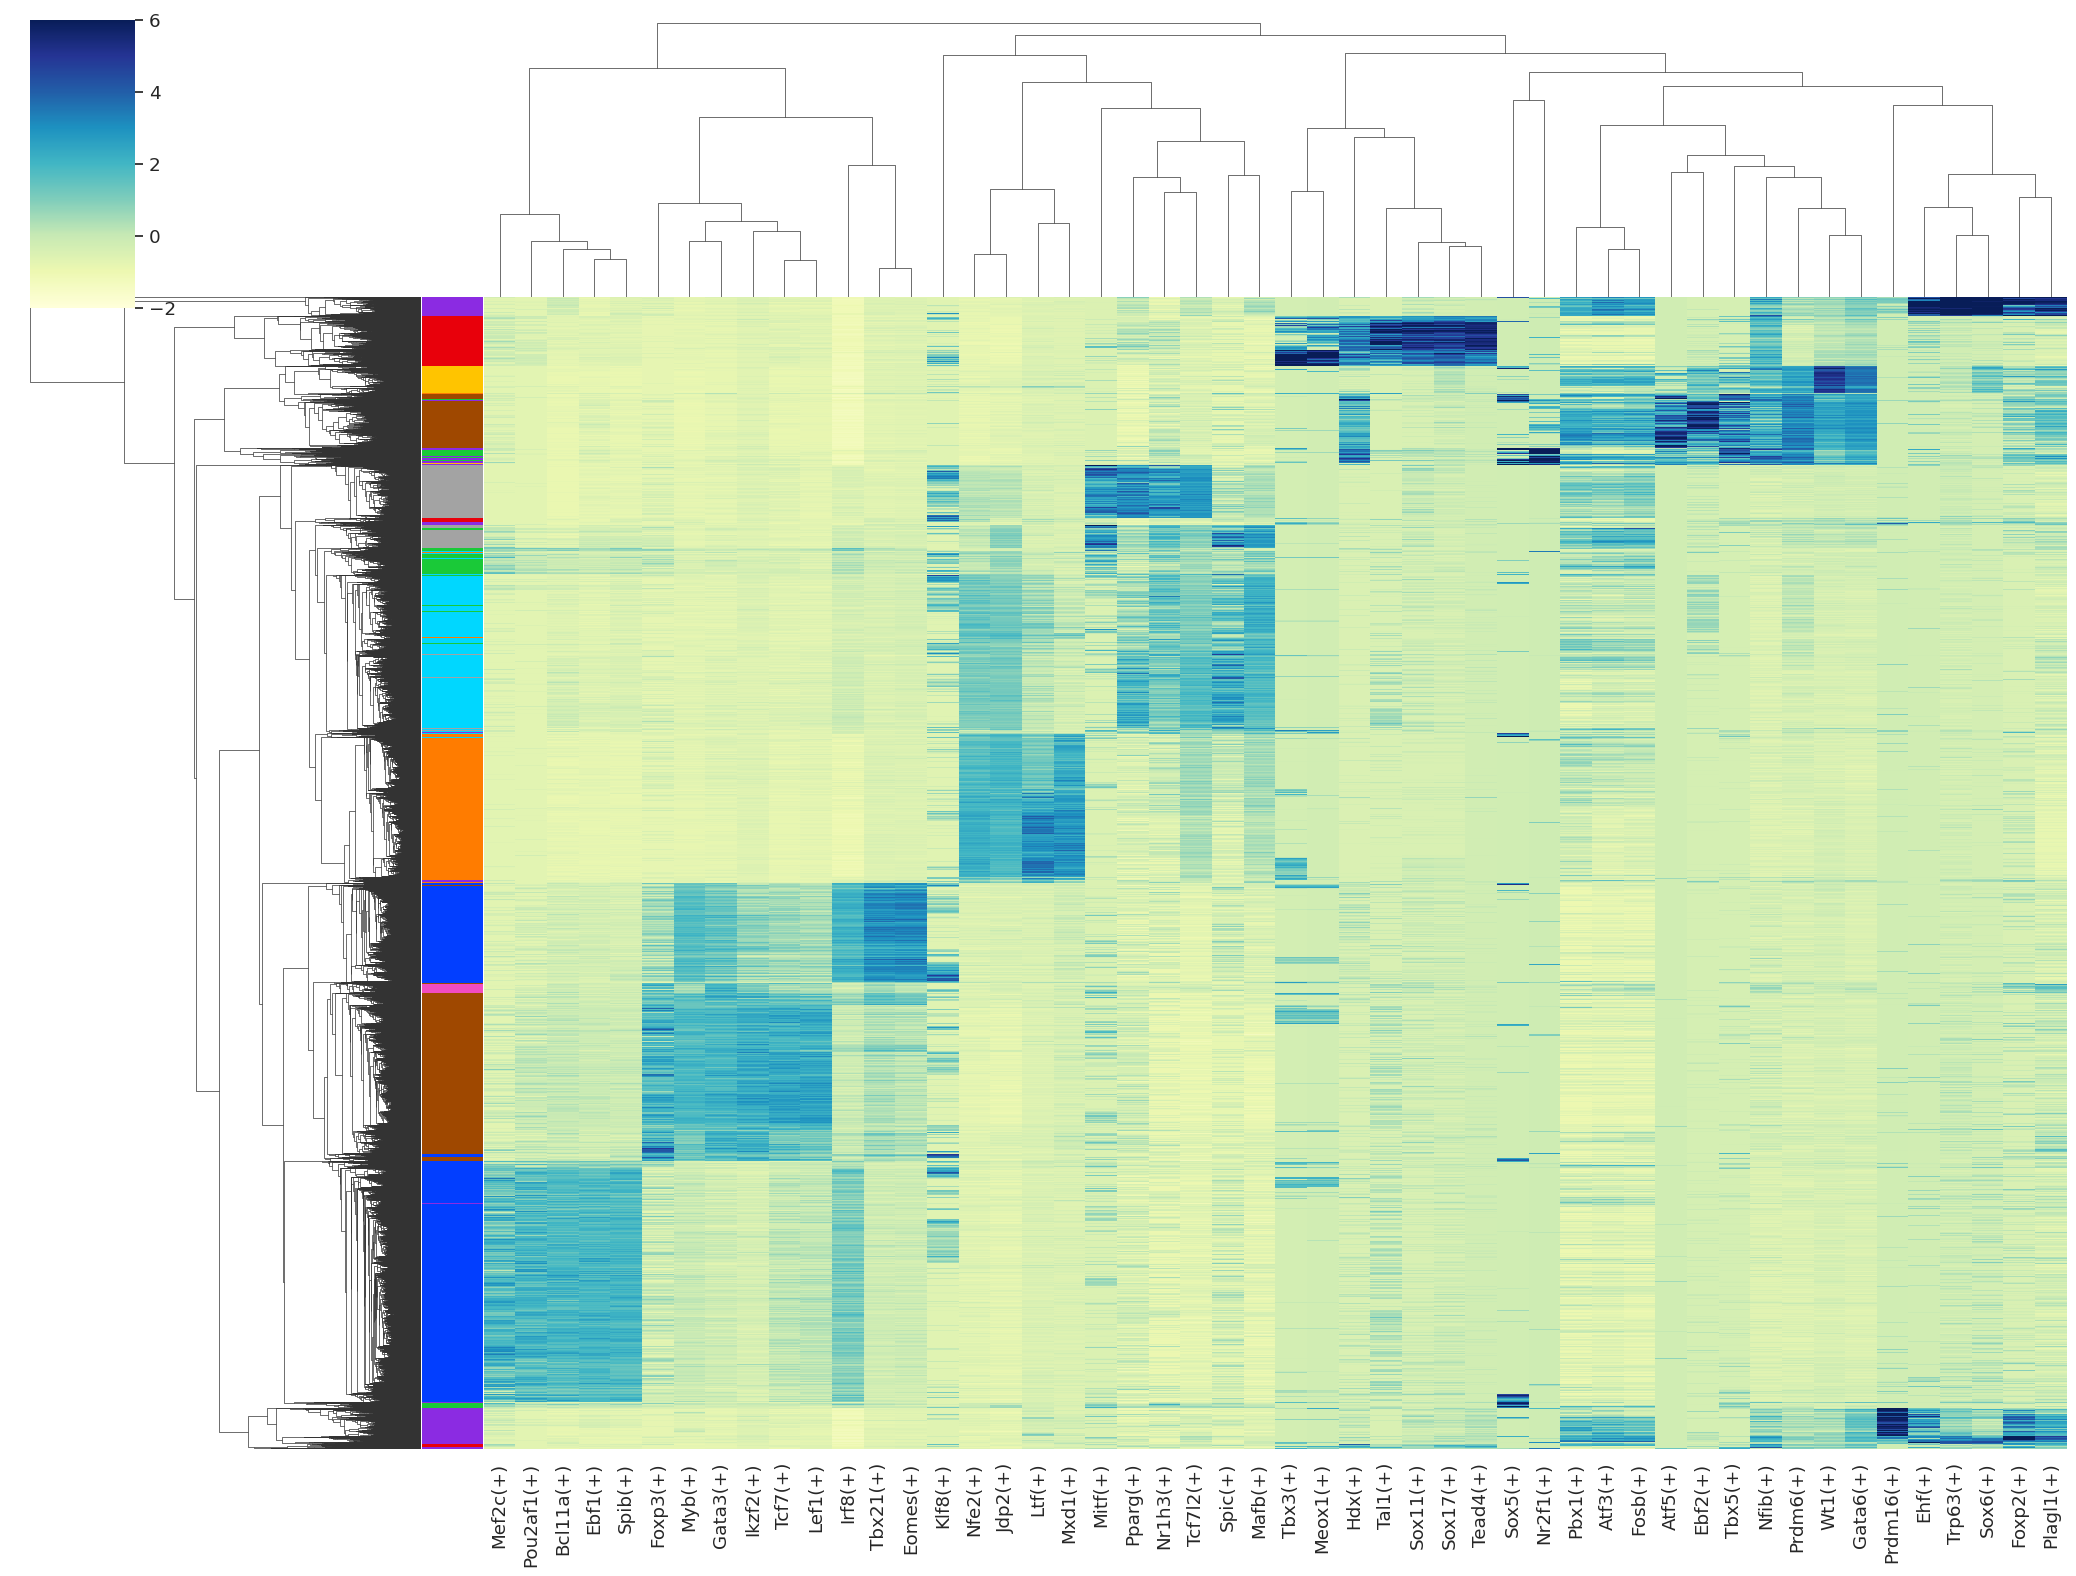

In [35]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('') 

## Dimensionality reduction

Here, I consider AUCell scoring as a kind of dimentionality reduction (like PCA), and generate a UMAP plots from the matrix. 

In [55]:
print(adata.obsm["X_aucell"].shape)
print(adata.obsm["X_pca"].shape)

(55129, 85)
(55129, 50)


The formly generated celltype annotations fit well in the new AUCell scoring-based UMAP.

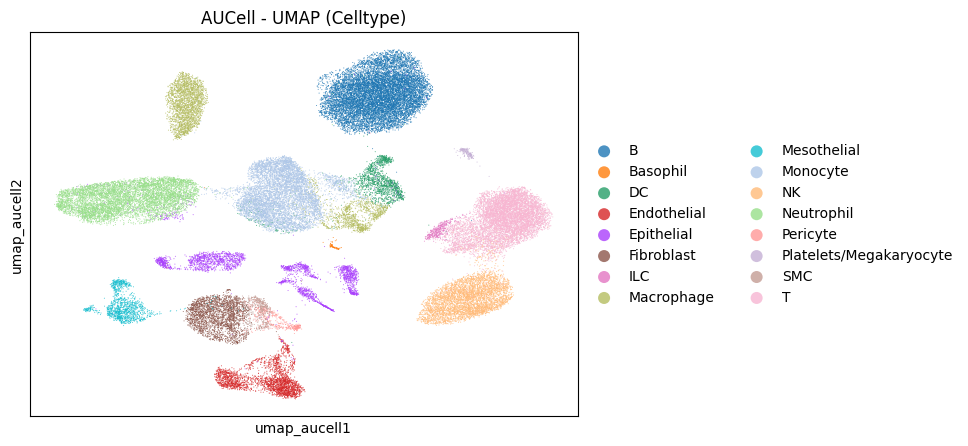

In [56]:
sc.pp.neighbors(adata, n_neighbors=15, metric="correlation", use_rep="X_aucell")
sc.tl.umap(adata, key_added= "X_umap_aucell")
sc.pl.scatter( adata, basis='umap_aucell', 
    color=['celltype'],
    title=['AUCell - UMAP (Celltype)'],
    alpha=0.8
    )

### Compared with routinely built UMAP Plots

In [57]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, use_rep="X_pca")
sc.tl.umap(adata, key_added= "X_umap_pca")

# Remove batch effect with Harmony
#!pip install harmonypy
#sc.external.pp.harmony_integrate(adata, key = "sample")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, use_rep="X_pca_harmony")
sc.tl.umap(adata, key_added= "X_umap_harmony")

Here, I compare the three UMAP plots:
* Based on PCA reduction with the highly_variable_genes
* Based on PCA after batch effect removing with `Harmonypy`
* Based on AUCell scoring matrix

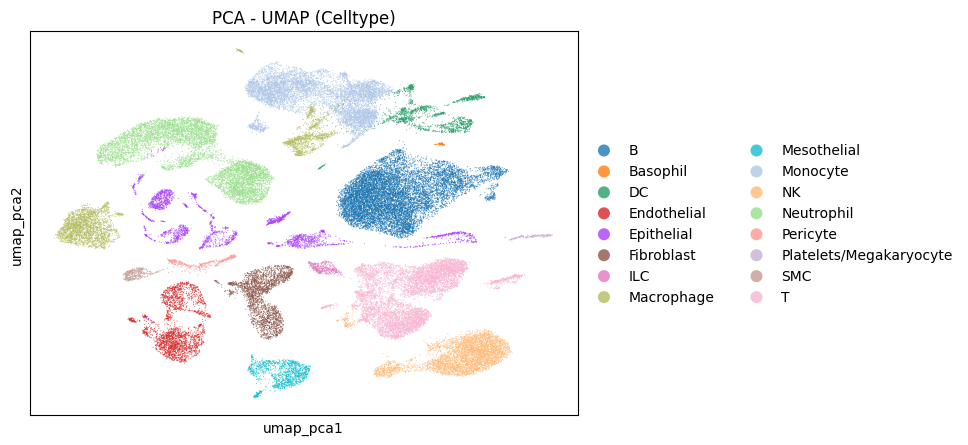

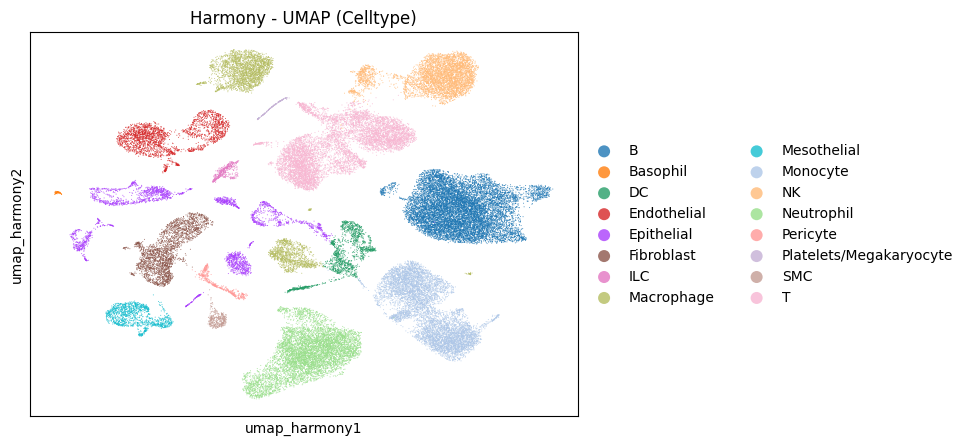

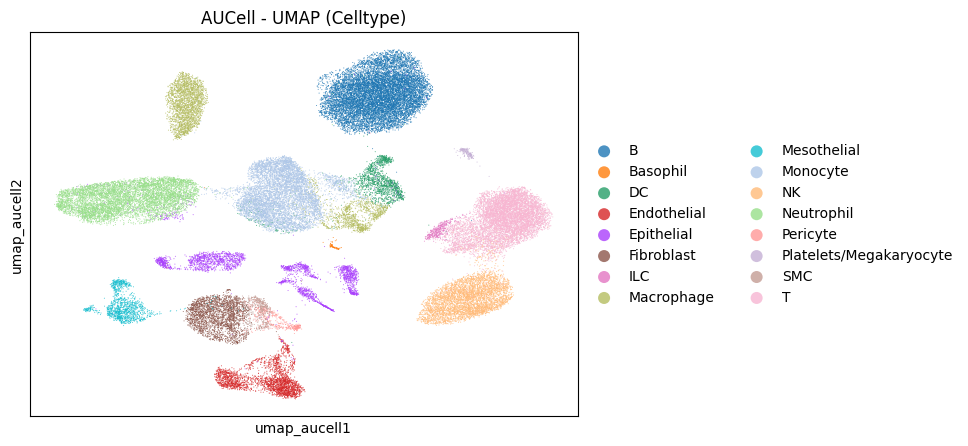

In [66]:
sc.pl.scatter( adata, basis='umap_pca', 
    color=['celltype'],
    title=['PCA - UMAP (Celltype)'],
    alpha=0.8
    )

sc.pl.scatter( adata, basis='umap_harmony', 
    color=['celltype'],
    title=['Harmony - UMAP (Celltype)'],
    alpha=0.8
    )

sc.pl.scatter( adata, basis='umap_aucell', 
    color=['celltype'],
    title=['AUCell - UMAP (Celltype)'],
    alpha=0.8
    )

### Markers

Let's see gene markers on the AUCell scoring-based UMAP plot.

[<Axes: title={'center': 'Ptprc'}, xlabel='umap_aucell1', ylabel='umap_aucell2'>,
 <Axes: title={'center': 'Mmp9'}, xlabel='umap_aucell1', ylabel='umap_aucell2'>,
 <Axes: title={'center': 'Cd14'}, xlabel='umap_aucell1', ylabel='umap_aucell2'>,
 <Axes: title={'center': 'Itgam'}, xlabel='umap_aucell1', ylabel='umap_aucell2'>,
 <Axes: title={'center': 'Marco'}, xlabel='umap_aucell1', ylabel='umap_aucell2'>,
 <Axes: title={'center': 'Clec9a'}, xlabel='umap_aucell1', ylabel='umap_aucell2'>,
 <Axes: title={'center': 'Ms4a1'}, xlabel='umap_aucell1', ylabel='umap_aucell2'>,
 <Axes: title={'center': 'Cd3d'}, xlabel='umap_aucell1', ylabel='umap_aucell2'>,
 <Axes: title={'center': 'Klrc1'}, xlabel='umap_aucell1', ylabel='umap_aucell2'>,
 <Axes: title={'center': 'Cd200r3'}, xlabel='umap_aucell1', ylabel='umap_aucell2'>,
 <Axes: title={'center': 'Il2ra'}, xlabel='umap_aucell1', ylabel='umap_aucell2'>,
 <Axes: title={'center': 'Itga2b'}, xlabel='umap_aucell1', ylabel='umap_aucell2'>,
 <Axes: title={

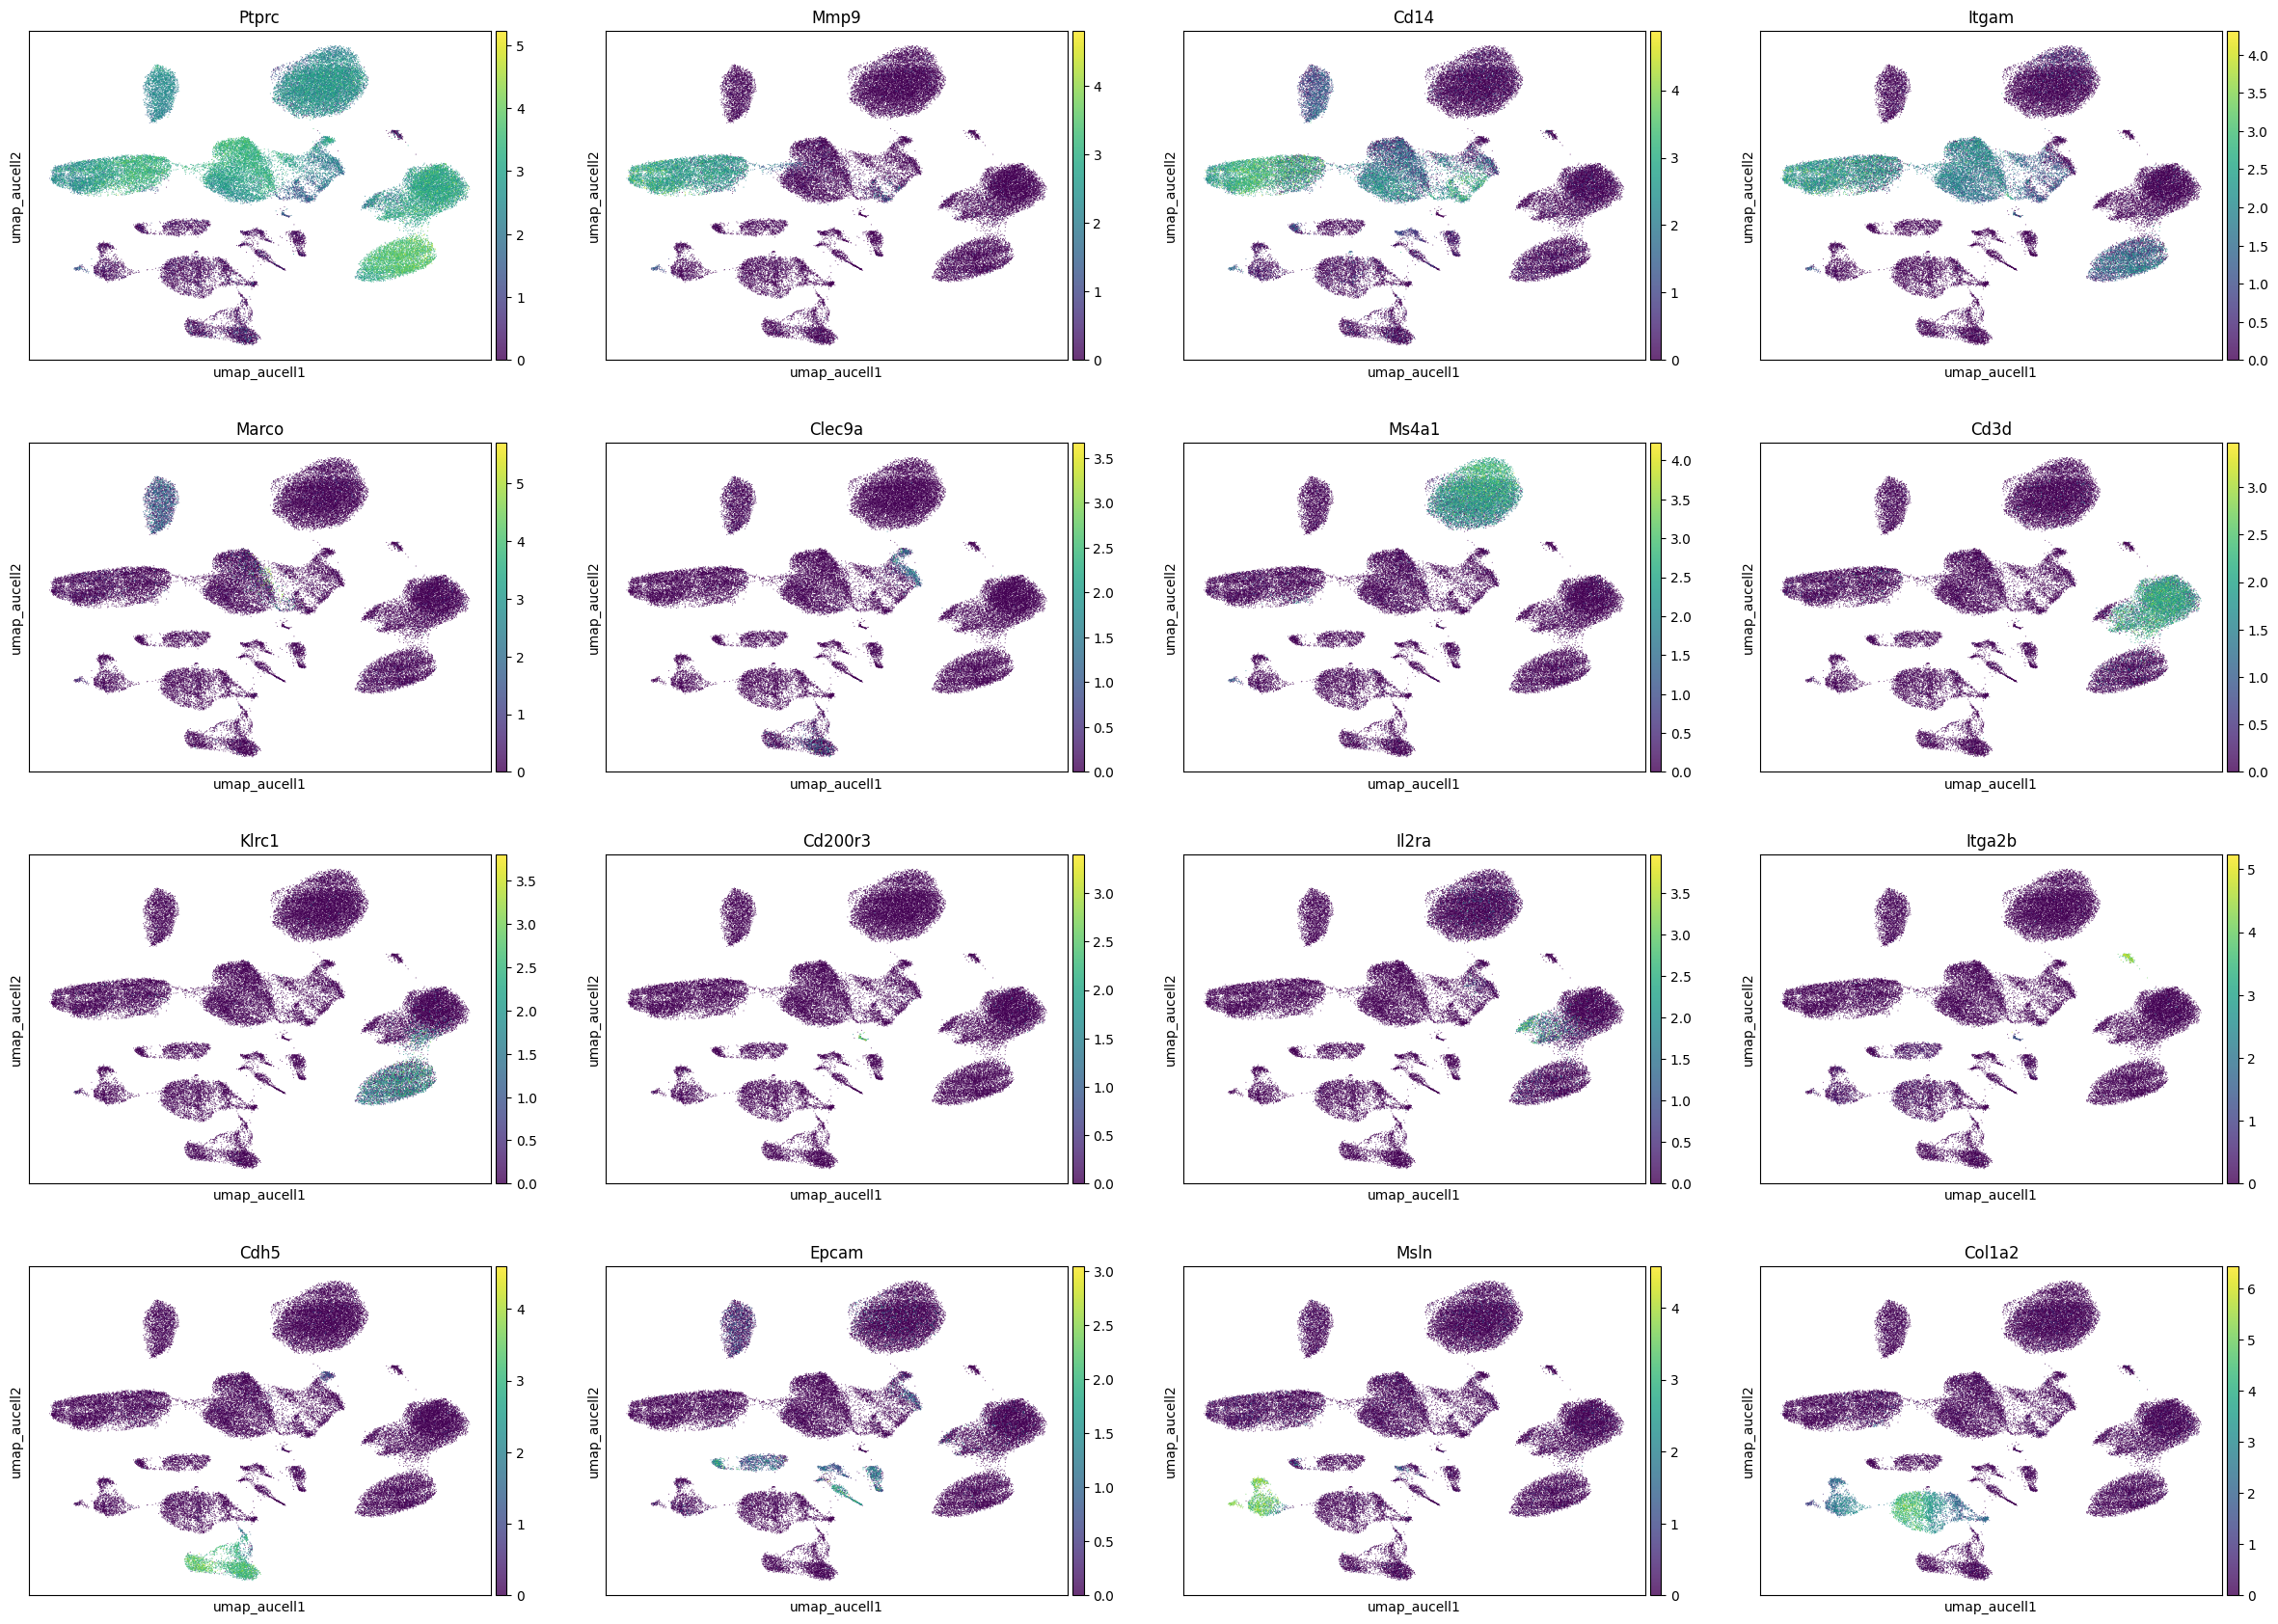

In [72]:
markers= ['Ptprc',
          'Mmp9', # Neutrophil
          'Cd14', 'Itgam',  # Monocyte
          'Marco',  # Macrophage
          'Clec9a',  # DC
          'Ms4a1', # B
          'Cd3d', # T
          'Klrc1',  # NK
          'Cd200r3',  # Basophil
          'Il2ra', # ILC
          'Itga2b', # Platelets
          'Cdh5', # Endothelial
          'Epcam', # Epithelial 
          'Msln', # Mesothelial
          'Col1a2' # Mesenchymal cells
]

sc.pl.embedding(
    adata, 
    basis='umap_aucell', 
    color=markers,      
    ncols=4,                     
    alpha=0.8,
    show=False          
)

### Batch effects

 As suggested by previous studies, AUCell scoring-based UMAP can work as a method to remove batch effect.

"Critically, we have shown that this methodology allows identification of sub populations that are essentially undetectable by gene-expression analysis, as well as robust, highly reproducible quantification of protein activity, which compares favorably with antibody-based single-cell measurements, as well as removal of technical artifacts and batch effects."

*Malagola, E., et al. 2024. Isthmus progenitor cells contribute to homeostatic cellular turnover and support regeneration following intestinal injury. Cell 187, 3056-3071.e17. https://doi.org/10.1016/j.cell.2024.05.004*

"The binary activity matrix tends to highlight higher order similarities across cells (and therefore highly reduces batch effects and technical biases); on the other hand, the AUC matrix allows researchers to observe more subtle changes.
……
This suggests that the scoring of network activity is robust and can be exploited to overcome batch or technical effects."

*Aibar, S., et al. 2017. SCENIC: single-cell regulatory network inference and clustering. Nat Methods 14, 1083–1086. https://doi.org/10.1038/nmeth.4463*

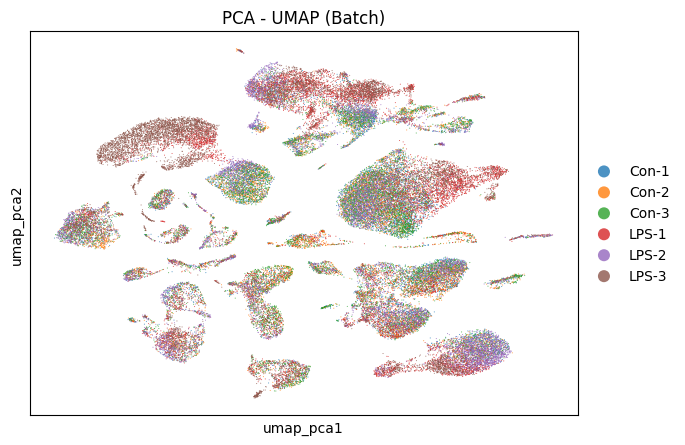

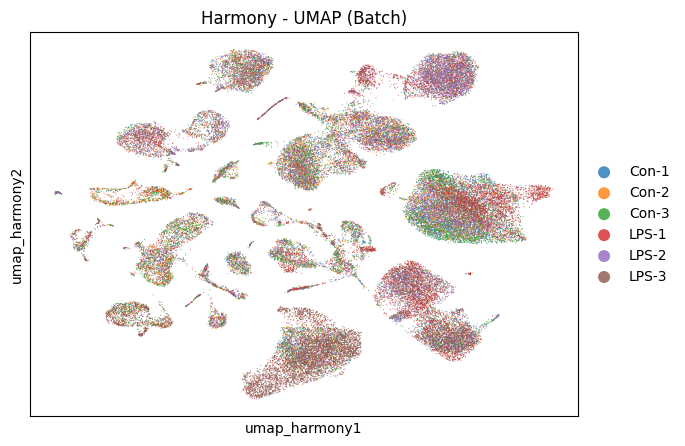

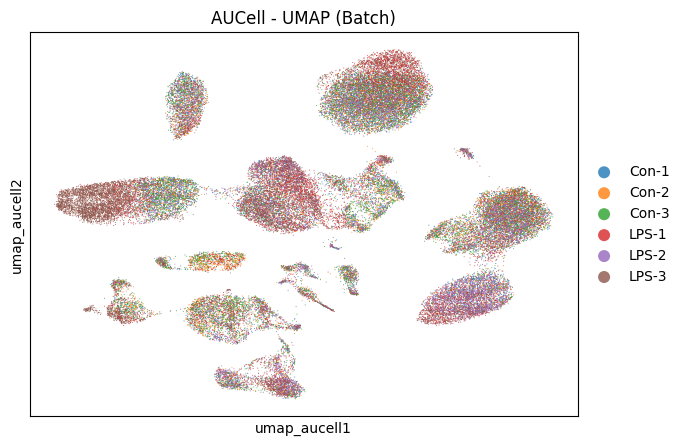

In [59]:
sc.pl.scatter( adata, basis='umap_pca', 
    color=['tag'],
    title=['PCA - UMAP (Batch)'],
    alpha=0.8
    )

sc.pl.scatter( adata, basis='umap_harmony', 
    color=['tag'],
    title=['Harmony - UMAP (Batch)'],
    alpha=0.8
    )

sc.pl.scatter( adata, basis='umap_aucell', 
    color=['tag'],
    title=['AUCell - UMAP (Batch)'],
    alpha=0.8
    )

# References

https://www.sc-best-practices.org/mechanisms/gene_regulatory_networks.html#takeaways

https://scanpy.readthedocs.io/en/stable/tutorials/index.html


https://pyscenic.readthedocs.io/en/latest/tutorial.html

https://htmlpreview.github.io/?https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_downstream-analysis.html


https://tuftsbcb.github.io/RegDiffusion/quick_tour.html
